In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
# Create the connection engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station 

In [15]:
# Create the inspector and connect it to the engine 
inspector = inspect(engine)

# Collect the table names within the database 
inspector.get_table_names()

['measurement', 'station']

In [16]:
# Use the inspector to print the column names within the 'measurement' table 
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# Use the inspector to print the column names within the 'station' table 
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Create the session (link) from Python to the database 
session = Session(engine)

# Exploratory Climate Analysis

## 1. Precipitation Analysis
Design a query to retrieve the last 12 months of precipitation data and plot the results

In [38]:
## Calculate the date 1 year ago from the last data point in the database 

# Last data point
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

# Convert the latest date into a datetime object 
latest_datetime = dt.datetime.strptime(latest_date[0], "%Y-%m-%d")
print("latest_datetime =", latest_datetime)

# Calculate the date 1 year ago from the latest date using dt.timedelta 
last_year = latest_datetime - dt.timedelta(days = 365)
print("last_year =", last_year)

latest_datetime = 2017-08-23 00:00:00
last_year = 2016-08-23 00:00:00


In [40]:
# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, measurement.prcp]

prcp_last_year = session.query(*sel).\
    filter(measurement.date < latest_datetime).\
    filter(measurement.date >= last_year).\
    order_by(measurement.date).all()
prcp_last_year

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.35),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.02),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 (

In [80]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_last_year, columns = ['Date', 'Precipitation'])

# Sort the dataframe by date and sort 
prcp_df.set_index('Date', inplace = True)
prcp_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


Text(0, 0.5, 'Inches')

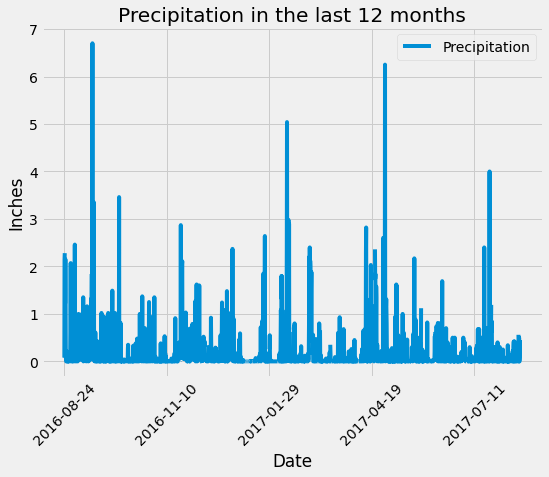

In [81]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot = 45, figsize = (8,6))
plt.title("Precipitation in the last 12 months")
plt.xlabel("Date")
plt.ylabel("Inches")

In [73]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## 2. Station Analysis
Design various queries on the stations table

In [87]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(station.id)).first()
print(f"There are a total of {str(num_stations[0])} stations!")

There are a total of 9 stations!


In [107]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(measurement.station, func.count(measurement.id)).\
                     group_by(measurement.station).\
                     order_by(func.count(measurement.id).desc()).all()
active_station_id = active_station[0][0]
active_station_id

'USC00519281'

In [118]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
sel = [measurement.station, 
      func.min(measurement.tobs),
      func.max(measurement.tobs),
      func.avg(measurement.tobs)]

temp_analysis = session.query(*sel).\
    filter(measurement.station == active_station_id).all()

print(f"Temperature Analysis for Station {active_station_id}: ")
print(f"  Min Temperature: {temp_analysis[0][1]}")
print(f"  Max Temperature: {temp_analysis[0][2]}")
print(f"  Avg Temperature: {temp_analysis[0][3]}")

Temperature Analysis for Station USC00519281: 
  Min Temperature: 54.0
  Max Temperature: 85.0
  Avg Temperature: 71.66378066378067


In [123]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
highest_temp_stn = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == active_station_id).\
    filter(measurement.date >= last_year).all()
highest_temp_stn

[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

In [124]:
# Save the query results as a Pandas DataFrame 
highest_temp_stn_df = pd.DataFrame(highest_temp_stn, columns = ['Date', 'Tobs'])
highest_temp_stn_df.head()

,Date,Tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


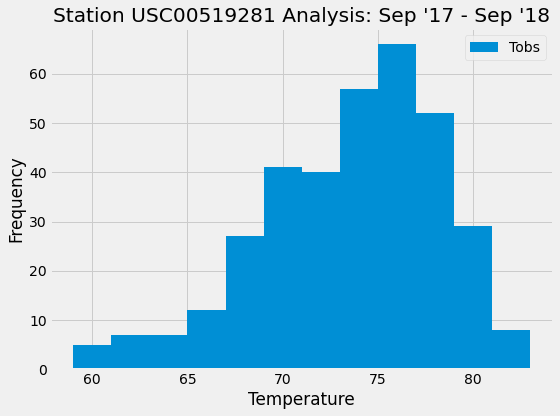

In [140]:
# Plot the histogram 
plt.figure(figsize = (8,6))
plt.hist(highest_temp_stn_df["Tobs"], bins = 12, label = "Tobs")
plt.title("Station " + active_station_id + " Analysis: Sep '17 - Sep '18")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
